## 13-9. Project: Face2Emoji Moblie WebApp

### GPU 확인

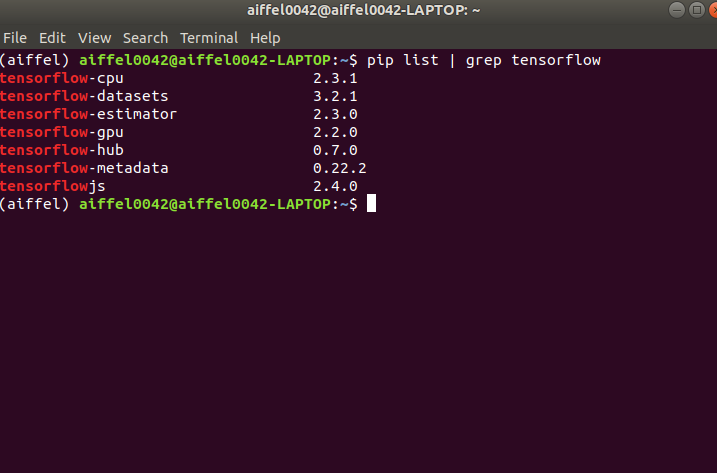

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Step 1. 표정 데이터로 MoblieNet 학습하기
- 기본으로 제공되는 **MoblieNet**은 **ImageNet**으로 학습 되었음
- **ImageNet** 데이터에서 갖고 있던 클래스들만 추론
- 공개 데이터로 얼굴 표정 분류 모델 만들기
- 각 표정에 이모티콘 지정하여 표시할 에정

### Step 1-1. Data Download
- Data Download
- https://www.kaggle.com/ahmedmoorsy/facial-expression
- move to folder (tfjs_moblie/data)

### Step 1-2. train, validation datasets 구성하기
- 필요한 학습 및 테스트 데이터는 ```fer2013.csv``` 파일에 모두 있음
- **emotion:** 감정 번호
- **pixels:** 얼굴 흑백 픽셀값
- **usage:** 용도
    - Training
    - PublicTest
    - Private Test
    - 각 비율 80%, 10%, 10%     
<br/>
- PrivateTest로 evaluation 데이터로 사용
- 나머지 데이터는 학습 데이터로 사용    
<br/>    
- pixels: X 항목
    - 48x48 pixel의 grayscale images(채널 1개)
    - grayscale은 0~255의 정수로 표현
    - x 항목을 (48, 48, 1)로 reshape
    - 255로 나누어 normalization
- emotion: y 항목


In [3]:
import numpy as np
import tqdm
import os

train_x = []
train_y = []
eval_x = []
eval_y = []

csv_path = os.getenv('HOME')+'/aiffel/tfjs_mobile/data/fer2013.csv'

with open(csv_path) as f:
  for line in tqdm.tqdm(f.read().splitlines()[1:]):
    emotion, pixels, usage = line.split(',')
    
    x = np.array(pixels.split(' ')).astype(float).reshape(48, 48, 1) / 255
    y = int(emotion)

    if usage == 'PrivateTest':
      eval_x.append(x)
      eval_y.append(y)
    else:
      train_x.append(x)
      train_y.append(y)

print('train : {}, eval :{}'.format(len(train_x), len(eval_x)))

100%|██████████| 35887/35887 [00:27<00:00, 1324.60it/s]

train : 32298, eval :3589


첫 번째 데이터의 이미지와 라벨 값 확인

Angry


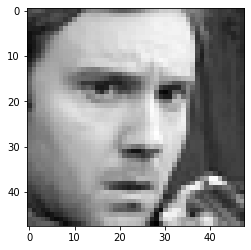

In [4]:
from matplotlib import pyplot as plt

LABELS = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

print(LABELS[train_y[0]])
plt.imshow(train_x[0].reshape([48, 48]), cmap='gray')

### Step 1-3. MobliNet 모델 학습하기

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('best.h5', monitor='val_categorical_accuracy', verbose=1, mode='auto', save_best_only=True)

In [15]:
# model 선언 
model = tf.keras.applications.MobileNetV2(input_shape=(48, 48, 1), weights=None, classes=7)

# model.compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

#model.fit
hist = model.fit(np.stack(train_x),
          tf.keras.utils.to_categorical(train_y),
          epochs=500,
          batch_size=512,
          validation_data=(np.stack(eval_x),
                           tf.keras.utils.to_categorical(eval_y)),
         callbacks=[mc])

Epoch 1/500
63/64 [============================>.] - ETA: 0s - loss: 1.8322 - categorical_accuracy: 0.2425
Epoch 00001: val_categorical_accuracy improved from -inf to 0.24492, saving model to best.h5
64/64 [==============================] - 7s 111ms/step - loss: 1.8321 - categorical_accuracy: 0.2426 - val_loss: 1.9300 - val_categorical_accuracy: 0.2449
Epoch 2/500
63/64 [============================>.] - ETA: 0s - loss: 1.7088 - categorical_accuracy: 0.3093
Epoch 00002: val_categorical_accuracy did not improve from 0.24492
64/64 [==============================] - 6s 99ms/step - loss: 1.7092 - categorical_accuracy: 0.3091 - val_loss: 1.9227 - val_categorical_accuracy: 0.2449
Epoch 3/500
63/64 [============================>.] - ETA: 0s - loss: 1.6006 - categorical_accuracy: 0.3722
Epoch 00003: val_categorical_accuracy did not improve from 0.24492
64/64 [==============================] - 6s 100ms/step - loss: 1.6006 - categorical_accuracy: 0.3722 - val_loss: 1.9180 - val_categorical_accur

Epoch 26/500
63/64 [============================>.] - ETA: 0s - loss: 0.3575 - categorical_accuracy: 0.8713
Epoch 00026: val_categorical_accuracy did not improve from 0.24492
64/64 [==============================] - 6s 101ms/step - loss: 0.3581 - categorical_accuracy: 0.8711 - val_loss: 2.0484 - val_categorical_accuracy: 0.1655
Epoch 27/500
63/64 [============================>.] - ETA: 0s - loss: 0.4205 - categorical_accuracy: 0.8499
Epoch 00027: val_categorical_accuracy did not improve from 0.24492
64/64 [==============================] - 7s 102ms/step - loss: 0.4209 - categorical_accuracy: 0.8497 - val_loss: 2.0907 - val_categorical_accuracy: 0.1655
Epoch 28/500
63/64 [============================>.] - ETA: 0s - loss: 0.3850 - categorical_accuracy: 0.8622
Epoch 00028: val_categorical_accuracy did not improve from 0.24492
64/64 [==============================] - 7s 102ms/step - loss: 0.3853 - categorical_accuracy: 0.8621 - val_loss: 2.1312 - val_categorical_accuracy: 0.1655
Epoch 29/5

Epoch 51/500
63/64 [============================>.] - ETA: 0s - loss: 0.1264 - categorical_accuracy: 0.9574
Epoch 00051: val_categorical_accuracy did not improve from 0.24492
64/64 [==============================] - 6s 100ms/step - loss: 0.1265 - categorical_accuracy: 0.9573 - val_loss: 2.6338 - val_categorical_accuracy: 0.1655
Epoch 52/500
63/64 [============================>.] - ETA: 0s - loss: 0.1614 - categorical_accuracy: 0.9442
Epoch 00052: val_categorical_accuracy did not improve from 0.24492
64/64 [==============================] - 6s 100ms/step - loss: 0.1614 - categorical_accuracy: 0.9441 - val_loss: 2.4588 - val_categorical_accuracy: 0.1655
Epoch 53/500
63/64 [============================>.] - ETA: 0s - loss: 0.1291 - categorical_accuracy: 0.9544
Epoch 00053: val_categorical_accuracy did not improve from 0.24492
64/64 [==============================] - 6s 101ms/step - loss: 0.1291 - categorical_accuracy: 0.9544 - val_loss: 2.5501 - val_categorical_accuracy: 0.1655
Epoch 54/5

64/64 [==============================] - 7s 106ms/step - loss: 0.1283 - categorical_accuracy: 0.9544 - val_loss: 3.1659 - val_categorical_accuracy: 0.2976
Epoch 76/500
63/64 [============================>.] - ETA: 0s - loss: 0.1247 - categorical_accuracy: 0.9578
Epoch 00076: val_categorical_accuracy improved from 0.29758 to 0.29925, saving model to best.h5
64/64 [==============================] - 7s 106ms/step - loss: 0.1247 - categorical_accuracy: 0.9578 - val_loss: 2.9046 - val_categorical_accuracy: 0.2992
Epoch 77/500
63/64 [============================>.] - ETA: 0s - loss: 0.0997 - categorical_accuracy: 0.9667
Epoch 00077: val_categorical_accuracy improved from 0.29925 to 0.33045, saving model to best.h5
64/64 [==============================] - 7s 105ms/step - loss: 0.0998 - categorical_accuracy: 0.9667 - val_loss: 2.7543 - val_categorical_accuracy: 0.3305
Epoch 78/500
63/64 [============================>.] - ETA: 0s - loss: 0.0920 - categorical_accuracy: 0.9693
Epoch 00078: val_ca

Epoch 100/500
63/64 [============================>.] - ETA: 0s - loss: 0.0833 - categorical_accuracy: 0.9705
Epoch 00100: val_categorical_accuracy did not improve from 0.41376
64/64 [==============================] - 6s 101ms/step - loss: 0.0833 - categorical_accuracy: 0.9705 - val_loss: 5.8416 - val_categorical_accuracy: 0.4001
Epoch 101/500
63/64 [============================>.] - ETA: 0s - loss: 0.0484 - categorical_accuracy: 0.9829
Epoch 00101: val_categorical_accuracy did not improve from 0.41376
64/64 [==============================] - 6s 100ms/step - loss: 0.0483 - categorical_accuracy: 0.9829 - val_loss: 5.7839 - val_categorical_accuracy: 0.4057
Epoch 102/500
63/64 [============================>.] - ETA: 0s - loss: 0.0356 - categorical_accuracy: 0.9874
Epoch 00102: val_categorical_accuracy did not improve from 0.41376
64/64 [==============================] - 7s 102ms/step - loss: 0.0356 - categorical_accuracy: 0.9874 - val_loss: 5.6492 - val_categorical_accuracy: 0.4062
Epoch 1

Epoch 125/500
63/64 [============================>.] - ETA: 0s - loss: 0.0791 - categorical_accuracy: 0.9727
Epoch 00125: val_categorical_accuracy did not improve from 0.42157
64/64 [==============================] - 6s 100ms/step - loss: 0.0791 - categorical_accuracy: 0.9726 - val_loss: 6.7392 - val_categorical_accuracy: 0.3948
Epoch 126/500
63/64 [============================>.] - ETA: 0s - loss: 0.0772 - categorical_accuracy: 0.9735
Epoch 00126: val_categorical_accuracy did not improve from 0.42157
64/64 [==============================] - 6s 101ms/step - loss: 0.0771 - categorical_accuracy: 0.9735 - val_loss: 7.2429 - val_categorical_accuracy: 0.3823
Epoch 127/500
63/64 [============================>.] - ETA: 0s - loss: 0.0591 - categorical_accuracy: 0.9797
Epoch 00127: val_categorical_accuracy did not improve from 0.42157
64/64 [==============================] - 6s 100ms/step - loss: 0.0593 - categorical_accuracy: 0.9796 - val_loss: 6.3344 - val_categorical_accuracy: 0.3982
Epoch 1

Epoch 150/500
63/64 [============================>.] - ETA: 0s - loss: 0.0930 - categorical_accuracy: 0.9670
Epoch 00150: val_categorical_accuracy did not improve from 0.42157
64/64 [==============================] - 6s 100ms/step - loss: 0.0931 - categorical_accuracy: 0.9670 - val_loss: 6.0768 - val_categorical_accuracy: 0.3486
Epoch 151/500
63/64 [============================>.] - ETA: 0s - loss: 0.0606 - categorical_accuracy: 0.9781
Epoch 00151: val_categorical_accuracy did not improve from 0.42157
64/64 [==============================] - 6s 100ms/step - loss: 0.0606 - categorical_accuracy: 0.9781 - val_loss: 6.1294 - val_categorical_accuracy: 0.3848
Epoch 152/500
63/64 [============================>.] - ETA: 0s - loss: 0.0584 - categorical_accuracy: 0.9796
Epoch 00152: val_categorical_accuracy did not improve from 0.42157
64/64 [==============================] - 6s 100ms/step - loss: 0.0584 - categorical_accuracy: 0.9795 - val_loss: 5.9535 - val_categorical_accuracy: 0.4062
Epoch 1

Epoch 175/500
63/64 [============================>.] - ETA: 0s - loss: 0.0512 - categorical_accuracy: 0.9821
Epoch 00175: val_categorical_accuracy did not improve from 0.42157
64/64 [==============================] - 6s 100ms/step - loss: 0.0513 - categorical_accuracy: 0.9820 - val_loss: 5.7877 - val_categorical_accuracy: 0.3770
Epoch 176/500
63/64 [============================>.] - ETA: 0s - loss: 0.0885 - categorical_accuracy: 0.9688
Epoch 00176: val_categorical_accuracy did not improve from 0.42157
64/64 [==============================] - 6s 100ms/step - loss: 0.0884 - categorical_accuracy: 0.9688 - val_loss: 6.0216 - val_categorical_accuracy: 0.3826
Epoch 177/500
63/64 [============================>.] - ETA: 0s - loss: 0.0293 - categorical_accuracy: 0.9902
Epoch 00177: val_categorical_accuracy did not improve from 0.42157
64/64 [==============================] - 6s 100ms/step - loss: 0.0293 - categorical_accuracy: 0.9902 - val_loss: 5.6327 - val_categorical_accuracy: 0.3926
Epoch 1

Epoch 200/500
63/64 [============================>.] - ETA: 0s - loss: 0.0220 - categorical_accuracy: 0.9918
Epoch 00200: val_categorical_accuracy did not improve from 0.42407
64/64 [==============================] - 6s 101ms/step - loss: 0.0222 - categorical_accuracy: 0.9917 - val_loss: 5.5262 - val_categorical_accuracy: 0.4135
Epoch 201/500
63/64 [============================>.] - ETA: 0s - loss: 0.0563 - categorical_accuracy: 0.9809
Epoch 00201: val_categorical_accuracy improved from 0.42407 to 0.42770, saving model to best.h5
64/64 [==============================] - 7s 105ms/step - loss: 0.0565 - categorical_accuracy: 0.9808 - val_loss: 5.2856 - val_categorical_accuracy: 0.4277
Epoch 202/500
63/64 [============================>.] - ETA: 0s - loss: 0.1251 - categorical_accuracy: 0.9559 ETA: 1s - loss: 0.1351 - cate
Epoch 00202: val_categorical_accuracy did not improve from 0.42770
64/64 [==============================] - 7s 102ms/step - loss: 0.1252 - categorical_accuracy: 0.9559 - 

Epoch 225/500
63/64 [============================>.] - ETA: 0s - loss: 0.0649 - categorical_accuracy: 0.9781
Epoch 00225: val_categorical_accuracy did not improve from 0.43884
64/64 [==============================] - 6s 100ms/step - loss: 0.0649 - categorical_accuracy: 0.9781 - val_loss: 5.6089 - val_categorical_accuracy: 0.3703
Epoch 226/500
63/64 [============================>.] - ETA: 0s - loss: 0.0457 - categorical_accuracy: 0.9843
Epoch 00226: val_categorical_accuracy improved from 0.43884 to 0.44163, saving model to best.h5
64/64 [==============================] - 7s 105ms/step - loss: 0.0465 - categorical_accuracy: 0.9840 - val_loss: 5.4202 - val_categorical_accuracy: 0.4416
Epoch 227/500
63/64 [============================>.] - ETA: 0s - loss: 0.1866 - categorical_accuracy: 0.9395
Epoch 00227: val_categorical_accuracy did not improve from 0.44163
64/64 [==============================] - 6s 101ms/step - loss: 0.1865 - categorical_accuracy: 0.9396 - val_loss: 5.6483 - val_categor

63/64 [============================>.] - ETA: 0s - loss: 0.1126 - categorical_accuracy: 0.9599
Epoch 00249: val_categorical_accuracy did not improve from 0.45444
64/64 [==============================] - 6s 101ms/step - loss: 0.1126 - categorical_accuracy: 0.9599 - val_loss: 5.2687 - val_categorical_accuracy: 0.4358
Epoch 250/500
63/64 [============================>.] - ETA: 0s - loss: 0.0528 - categorical_accuracy: 0.9812
Epoch 00250: val_categorical_accuracy did not improve from 0.45444
64/64 [==============================] - 6s 101ms/step - loss: 0.0529 - categorical_accuracy: 0.9811 - val_loss: 5.0329 - val_categorical_accuracy: 0.4450
Epoch 251/500
63/64 [============================>.] - ETA: 0s - loss: 0.0450 - categorical_accuracy: 0.9844
Epoch 00251: val_categorical_accuracy did not improve from 0.45444
64/64 [==============================] - 6s 101ms/step - loss: 0.0450 - categorical_accuracy: 0.9844 - val_loss: 5.2320 - val_categorical_accuracy: 0.4525
Epoch 252/500
63/64 [

Epoch 274/500
63/64 [============================>.] - ETA: 0s - loss: 0.0699 - categorical_accuracy: 0.9764
Epoch 00274: val_categorical_accuracy did not improve from 0.46030
64/64 [==============================] - 6s 100ms/step - loss: 0.0700 - categorical_accuracy: 0.9763 - val_loss: 5.2375 - val_categorical_accuracy: 0.4369
Epoch 275/500
63/64 [============================>.] - ETA: 0s - loss: 0.0945 - categorical_accuracy: 0.9673
Epoch 00275: val_categorical_accuracy did not improve from 0.46030
64/64 [==============================] - 6s 101ms/step - loss: 0.0946 - categorical_accuracy: 0.9673 - val_loss: 5.0839 - val_categorical_accuracy: 0.4400
Epoch 276/500
63/64 [============================>.] - ETA: 0s - loss: 0.0573 - categorical_accuracy: 0.9799
Epoch 00276: val_categorical_accuracy did not improve from 0.46030
64/64 [==============================] - 6s 101ms/step - loss: 0.0574 - categorical_accuracy: 0.9799 - val_loss: 5.2992 - val_categorical_accuracy: 0.4358
Epoch 2

Epoch 299/500
63/64 [============================>.] - ETA: 0s - loss: 0.0324 - categorical_accuracy: 0.9881
Epoch 00299: val_categorical_accuracy did not improve from 0.46030
64/64 [==============================] - 7s 102ms/step - loss: 0.0324 - categorical_accuracy: 0.9881 - val_loss: 5.3269 - val_categorical_accuracy: 0.4413
Epoch 300/500
63/64 [============================>.] - ETA: 0s - loss: 0.0147 - categorical_accuracy: 0.9940
Epoch 00300: val_categorical_accuracy did not improve from 0.46030
64/64 [==============================] - 6s 101ms/step - loss: 0.0149 - categorical_accuracy: 0.9939 - val_loss: 5.5523 - val_categorical_accuracy: 0.4450
Epoch 301/500
63/64 [============================>.] - ETA: 0s - loss: 0.0854 - categorical_accuracy: 0.9718
Epoch 00301: val_categorical_accuracy did not improve from 0.46030
64/64 [==============================] - 6s 101ms/step - loss: 0.0853 - categorical_accuracy: 0.9718 - val_loss: 5.5207 - val_categorical_accuracy: 0.4349
Epoch 3

Epoch 324/500
63/64 [============================>.] - ETA: 0s - loss: 0.0170 - categorical_accuracy: 0.9935
Epoch 00324: val_categorical_accuracy did not improve from 0.46197
64/64 [==============================] - 6s 101ms/step - loss: 0.0170 - categorical_accuracy: 0.9935 - val_loss: 5.1249 - val_categorical_accuracy: 0.4405
Epoch 325/500
63/64 [============================>.] - ETA: 0s - loss: 0.0101 - categorical_accuracy: 0.9960
Epoch 00325: val_categorical_accuracy did not improve from 0.46197
64/64 [==============================] - 6s 100ms/step - loss: 0.0101 - categorical_accuracy: 0.9960 - val_loss: 5.0383 - val_categorical_accuracy: 0.4411
Epoch 326/500
63/64 [============================>.] - ETA: 0s - loss: 0.0107 - categorical_accuracy: 0.9958
Epoch 00326: val_categorical_accuracy did not improve from 0.46197
64/64 [==============================] - 6s 101ms/step - loss: 0.0108 - categorical_accuracy: 0.9957 - val_loss: 4.8679 - val_categorical_accuracy: 0.4492
Epoch 3

Epoch 349/500
63/64 [============================>.] - ETA: 0s - loss: 0.0143 - categorical_accuracy: 0.9950
Epoch 00349: val_categorical_accuracy did not improve from 0.46197
64/64 [==============================] - 6s 100ms/step - loss: 0.0145 - categorical_accuracy: 0.9949 - val_loss: 5.0772 - val_categorical_accuracy: 0.4455
Epoch 350/500
63/64 [============================>.] - ETA: 0s - loss: 0.0206 - categorical_accuracy: 0.9922
Epoch 00350: val_categorical_accuracy did not improve from 0.46197
64/64 [==============================] - 6s 100ms/step - loss: 0.0209 - categorical_accuracy: 0.9922 - val_loss: 5.1769 - val_categorical_accuracy: 0.4383
Epoch 351/500
63/64 [============================>.] - ETA: 0s - loss: 0.0649 - categorical_accuracy: 0.9787
Epoch 00351: val_categorical_accuracy improved from 0.46197 to 0.46475, saving model to best.h5
64/64 [==============================] - 7s 105ms/step - loss: 0.0649 - categorical_accuracy: 0.9786 - val_loss: 5.0650 - val_categor

Epoch 374/500
63/64 [============================>.] - ETA: 0s - loss: 0.0522 - categorical_accuracy: 0.9823
Epoch 00374: val_categorical_accuracy did not improve from 0.46475
64/64 [==============================] - 6s 100ms/step - loss: 0.0523 - categorical_accuracy: 0.9822 - val_loss: 4.4696 - val_categorical_accuracy: 0.4533
Epoch 375/500
63/64 [============================>.] - ETA: 0s - loss: 0.0367 - categorical_accuracy: 0.9872
Epoch 00375: val_categorical_accuracy did not improve from 0.46475
64/64 [==============================] - 6s 101ms/step - loss: 0.0370 - categorical_accuracy: 0.9872 - val_loss: 4.3907 - val_categorical_accuracy: 0.4642
Epoch 376/500
63/64 [============================>.] - ETA: 0s - loss: 0.0628 - categorical_accuracy: 0.9786
Epoch 00376: val_categorical_accuracy did not improve from 0.46475
64/64 [==============================] - 6s 101ms/step - loss: 0.0629 - categorical_accuracy: 0.9786 - val_loss: 4.8894 - val_categorical_accuracy: 0.4235
Epoch 3

Epoch 399/500
63/64 [============================>.] - ETA: 0s - loss: 0.0127 - categorical_accuracy: 0.9953
Epoch 00399: val_categorical_accuracy did not improve from 0.46475
64/64 [==============================] - 6s 100ms/step - loss: 0.0127 - categorical_accuracy: 0.9953 - val_loss: 4.7970 - val_categorical_accuracy: 0.4531
Epoch 400/500
63/64 [============================>.] - ETA: 0s - loss: 0.0067 - categorical_accuracy: 0.9969
Epoch 00400: val_categorical_accuracy did not improve from 0.46475
64/64 [==============================] - 6s 101ms/step - loss: 0.0072 - categorical_accuracy: 0.9967 - val_loss: 4.8436 - val_categorical_accuracy: 0.4433
Epoch 401/500
63/64 [============================>.] - ETA: 0s - loss: 0.1034 - categorical_accuracy: 0.9660
Epoch 00401: val_categorical_accuracy did not improve from 0.46475
64/64 [==============================] - 6s 101ms/step - loss: 0.1036 - categorical_accuracy: 0.9659 - val_loss: 4.8343 - val_categorical_accuracy: 0.4302
Epoch 4

Epoch 424/500
63/64 [============================>.] - ETA: 0s - loss: 0.0237 - categorical_accuracy: 0.9915
Epoch 00424: val_categorical_accuracy did not improve from 0.47172
64/64 [==============================] - 6s 100ms/step - loss: 0.0237 - categorical_accuracy: 0.9915 - val_loss: 4.4711 - val_categorical_accuracy: 0.4689
Epoch 425/500
63/64 [============================>.] - ETA: 0s - loss: 0.0108 - categorical_accuracy: 0.9956
Epoch 00425: val_categorical_accuracy did not improve from 0.47172
64/64 [==============================] - 6s 101ms/step - loss: 0.0108 - categorical_accuracy: 0.9956 - val_loss: 4.5793 - val_categorical_accuracy: 0.4714
Epoch 426/500
63/64 [============================>.] - ETA: 0s - loss: 0.0063 - categorical_accuracy: 0.9972
Epoch 00426: val_categorical_accuracy improved from 0.47172 to 0.47618, saving model to best.h5
64/64 [==============================] - 7s 105ms/step - loss: 0.0063 - categorical_accuracy: 0.9972 - val_loss: 4.6364 - val_categor

Epoch 449/500
63/64 [============================>.] - ETA: 0s - loss: 0.0196 - categorical_accuracy: 0.9928
Epoch 00449: val_categorical_accuracy did not improve from 0.49178
64/64 [==============================] - 6s 100ms/step - loss: 0.0197 - categorical_accuracy: 0.9928 - val_loss: 4.7281 - val_categorical_accuracy: 0.4717
Epoch 450/500
63/64 [============================>.] - ETA: 0s - loss: 0.0279 - categorical_accuracy: 0.9897
Epoch 00450: val_categorical_accuracy did not improve from 0.49178
64/64 [==============================] - 6s 100ms/step - loss: 0.0279 - categorical_accuracy: 0.9897 - val_loss: 4.8227 - val_categorical_accuracy: 0.4567
Epoch 451/500
63/64 [============================>.] - ETA: 0s - loss: 0.0266 - categorical_accuracy: 0.9898
Epoch 00451: val_categorical_accuracy did not improve from 0.49178
64/64 [==============================] - 6s 101ms/step - loss: 0.0266 - categorical_accuracy: 0.9898 - val_loss: 4.6883 - val_categorical_accuracy: 0.4692
Epoch 4

Epoch 474/500
63/64 [============================>.] - ETA: 0s - loss: 0.0458 - categorical_accuracy: 0.9841
Epoch 00474: val_categorical_accuracy did not improve from 0.49178
64/64 [==============================] - 6s 101ms/step - loss: 0.0459 - categorical_accuracy: 0.9841 - val_loss: 4.6455 - val_categorical_accuracy: 0.4726
Epoch 475/500
63/64 [============================>.] - ETA: 0s - loss: 0.0343 - categorical_accuracy: 0.9878
Epoch 00475: val_categorical_accuracy did not improve from 0.49178
64/64 [==============================] - 6s 101ms/step - loss: 0.0346 - categorical_accuracy: 0.9877 - val_loss: 4.9404 - val_categorical_accuracy: 0.4586
Epoch 476/500
63/64 [============================>.] - ETA: 0s - loss: 0.0357 - categorical_accuracy: 0.9871
Epoch 00476: val_categorical_accuracy did not improve from 0.49178
64/64 [==============================] - 6s 101ms/step - loss: 0.0359 - categorical_accuracy: 0.9870 - val_loss: 4.7760 - val_categorical_accuracy: 0.4639
Epoch 4

Epoch 499/500
63/64 [============================>.] - ETA: 0s - loss: 0.0162 - categorical_accuracy: 0.9936
Epoch 00499: val_categorical_accuracy did not improve from 0.49178
64/64 [==============================] - 6s 101ms/step - loss: 0.0161 - categorical_accuracy: 0.9937 - val_loss: 4.8269 - val_categorical_accuracy: 0.4759
Epoch 500/500
63/64 [============================>.] - ETA: 0s - loss: 0.0077 - categorical_accuracy: 0.9967
Epoch 00500: val_categorical_accuracy did not improve from 0.49178
64/64 [==============================] - 6s 100ms/step - loss: 0.0077 - categorical_accuracy: 0.9966 - val_loss: 4.7279 - val_categorical_accuracy: 0.4689


### Step 2. 학습된 모델을 TensoFlow.js 형식으로 변환하기
- 학습 완료되면 케라스의 경우 모델을 HDF(.h5) 형식으로 저장
- TensorFLow.js converter에서 지원하는 다른 형식으로 저장해도 무관

**학습 정확성 값과 검증 정확성 값을 플롯팅**

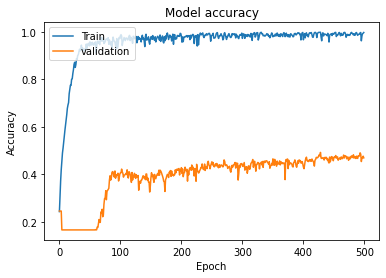

In [19]:
plt.plot(hist.history['categorical_accuracy'])
plt.plot(hist.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')
plt.show()

**저장 확인**

In [20]:
import os
model_path = os.getenv('HOME')+'/aiffel/tfjs_mobile/model.h5'
model.save(model_path)

- ```tonsorflowjs_converter```를 활용하여 저장한 모델을 Tensorflow.js가 활용할 수 있는 형태로 변환해야하 함
- 우선, tensorflowjs 설치 ($ pip install tensorflowjs)

- 저장한 모델 TensorFlow.js로 변환 작업
- ```tensorflowjs_converter```명령어 실행
- tensorflow/tfjs/tfjs-converter 참고
- https://github.com/tensorflow/tfjs/tree/master/tfjs-converter

- $ cd ~/aiffel/tfjs_mobile     
- $ tensorflowjs_converter --input_format=keras model.h5 model
- ```~/aiffel/tfjs_mobile/model``` 디렉토리에 model.json 및 모델 파일들이 정상적으로 생성되었음을 확인

---

### Step 3. 카메라에서 가져온 영상 전처리하기
- 참조한 데이터는 가로, 세로 각 48 픽셀의 정사각형 흑백 이미지
- 카메라 영상에서 가져온 ```<canvas>``` 내의 이미지는 기기마다 가로, 세로 크기가 다르고, RGB 색상을 가지고 있음
- 캡쳐 화면을 48x48 흑백 이미지로 변환하는 전처리 필요 -> Javascript 활용

In [8]:
# <button>Take snapshot</button>
#     <canvas></canvas>
#     <script>
#     video = document.querySelector('video');
#     canvas = document.querySelector('canvas');
#     button = document.querySelector('button');

#     button.onclick = function() {
#       canvas.width = video.videoWidth;
#       canvas.height = video.videoHeight;
#       canvas.getContext('2d').drawImage(video, 0, 0, video.videoWidth, video.videoHeight);
#     };

- 버튼 타이틀: ```Capture```
- ```<canvas>``` 선언부에서 사이즈 가로, 세로 48로 맞추기
- grayscale style 부여
- 버튼 클릭시, 이 사이즈에 맞게 캡쳐한 이미지 ```<canvas>```에 그려 주기
- 모바일 환경 고려하여 video의 좌우 반전 효과

**효과가 적용된 스크립트**

In [9]:
# <button>Take snapshot</button>
#     <canvas></canvas>
#     <script>
#       video = document.querySelector('video');
#       canvas = document.querySelector('canvas');
#       canvas.width = 48;
#       canvas.height = 48;
#       canvas.style.filter = 'grayscale(1)';
#       video.style.transform = 'scaleX(-1)';

#     button.onclick = function() {
#         w = video.videoWidth;
#         h = video.videoHeight;
#         s = Math.min(w, h);
#         sx = (w-s)/2;
#         sy = (h-s)/2;

#         canvas.getContext('2d').drawImage(video, sx=sx, sy=sy, swidth=s,
#           sheight=s, x=0, y=0, width=48, height=48);
#     };

### Step 4. MoblieNet 추론 결과 표시하기
- TensorFlow.js의 API를 활용
- 모델이 추론한 결과 중 가장 큰 값의 클래스를 가져옴
- Javascript를 활용해 각 감정에 해당하는 이모티콘을 웹 브라우저 화면에 추가
- 이모티콘을 그리기 위한 자리를 ```<span>```태그 활용해 생성
- ```<span></span>``` 태그를 ```<canvas></convas>``` 아래 만들어 줌
- 7가지 감정을 표현하는 LABELS 선언

In [10]:
# <button>Take snapshot</button>
#     <canvas></canvas>
#     <script>
#       video = document.querySelector('video');
#       canvas = document.querySelector('canvas');
#       canvas.width = 48;
#       canvas.height = 48;
#       canvas.style.filter = 'grayscale(1)';
#       video.style.transform = 'scaleX(-1)';

#       span = document.querySelector('span');
#       span.style.fontSize = '48px';

#       const LABELS = {
#         0: '🤬', // angry
#         1: '🤢', // disgust
#         2: '😱', // fear
#         3: '😄', // happy
#         4: '😢', // sad
#         5: '😲', // surprise
#         6: '😐' // neutral
#       }

- ```button.onclick``` 이벤트 핸들러에서 사용할 MoblieNet 모델 predict() 메소드를 다음과 같이 선언

In [11]:
#      async function predict() {
#         const model = await tf.loadLayersModel('./model/model.json');

#         image = tf.browser.fromPixels(canvas);
#         console.log(image);
#         image = image.toFloat().mean(2).mul(1/255.0).reshape([-1, 48, 48, 1]);
#         logits = model.predict(image);
#         const results = await logits.softmax().data();
#         i = results.indexOf(Math.max(...results));

#         image.dispose();
#         logits.dispose();
#         console.log(results);

#         span.innerHTML = LABELS[i];
#       }

- ```button.onclick``` 이벤트 핸들러 변경

In [12]:
#     button.onclick = function() {
#         w = video.videoWidth;
#         h = video.videoHeight;
#         s = Math.min(w, h);
#         sx = (w-s)/2;
#         sy = (h-s)/2;

#         canvas.getContext('2d').drawImage(video, sx=sx, sy=sy, swidth=s,
#           sheight=s, x=0, y=0, width=48, height=48);

#         span.innerHTML = '⌛';
#         predict();
#     };

### 최종 index.html

In [13]:
# <html>
#   <head>
#     <meta charset="utf-8">
#     <meta name="viewport" content="width=device-width, user-scalable=yes, initial-scale=1, maximum-scale=1">
#     <title>Demo</title>
#     <script src="https://cdn.jsdelivr.net/npm/@tensorflow/tfjs@1.0.1"></script>
#   </head>
#   <body>
#     <video playsinline autoplay></video>
#     <button>Take snapshot</button>
#     <canvas></canvas>
#     <span></span>
#     <script>
#       video = document.querySelector('video');
#       canvas = document.querySelector('canvas');
#       button = document.querySelector('button');
#       canvas.width = 48;
#       canvas.height = 48;
#       canvas.style.filter = 'grayscale(1)';
#       video.style.transform = 'scaleX(-1)';

#       span = document.querySelector('span');
#       span.style.fontSize = '48px';


#       const LABELS = {
#         0: '🤬', // angry
#         1: '🤢', // disgust
#         2: '😱', // fear
#         3: '😄', // happy
#         4: '😢', // sad
#         5: '😲', // surprise
#         6: '😐' // neutral
#       }
      
#       function classifyCallback(predictions) {
#         alert(predictions[0].className + ':' + predictions[0].probabaility);
#       }

#       async function predict() {
#         const model = await tf.loadLayersModel('./model/model.json');

#         image = tf.browser.fromPixels(canvas);
#         console.log(image);
#         image = image.toFloat().mean(2).mul(1/255.0).reshape([-1, 48, 48, 1]);
#         logits = model.predict(image);
#         const results = await logits.softmax().data();
#         i = results.indexOf(Math.max(...results));

#         image.dispose();
#         logits.dispose();
#         console.log(results);
        
#         span.innerHTML = LABELS[i];
#       }

#       button.onclick = function() {
#         w = video.videoWidth;
#         h = video.videoHeight;
#         s = Math.min(w, h);
#         sx = (w-s)/2;
#         sy = (h-s)/2;

#         canvas.getContext('2d').drawImage(video, sx=sx, sy=sy, swidth=s,
#           sheight=s, x=0, y=0, width=48, height=48);

#         span.innerHTML = '⌛';
#         predict();
#     };


#     constraints = {
#       audio: false,
#       video: true
#     };

#     function handleSuccess(stream) {
#       video.srcObject = stream;
#     }

#     function handleError(error) {
#       alert('navigator.MediaDevices.getUserMedia error: ' + error.message + error.name);
#     }

#     navigator.mediaDevices.getUserMedia(constraints).then(handleSuccess).catch(handleError);
# </script>
#   </body>
# </html>